In [2]:
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, models
import os
import matplotlib.pyplot as plt

import pandas as pd
from torchvision.io import read_image
from torchvision import transforms
from torch.utils.data import Dataset
import pickle
from PIL import Image
import numpy as np

vgg16 = models.vgg16(pretrained=True).cuda()
print(vgg16.features[:9])

C:\Users\joyce\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\joyce\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
)


## Load Dataset

In [7]:
IMG_WIDTH = 520/2 #1280/2
IMG_HEIGHT = 240/2 #720/2

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

test_transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

_TRAIN_TRANSFORM = transforms.Compose([transforms.RandomResizedCrop((224, 224), (0.8, 1.0)),
                                       transforms.RandomGrayscale(p=0.05),
                                       transforms.ColorJitter(brightness=0.4, contrast=0.3, saturation=0.3, hue=0.3),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                std=[0.229, 0.224, 0.225])])
_TEST_TRANSFORM = transforms.Compose([transforms.Resize((224, 224)),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                                                                std=[0.229, 0.224, 0.225])])

class CustomImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = test_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        with open(img_path, 'rb') as handle:
            frame_data = pickle.load(handle)
            image = frame_data['rgb']
            # image = rgb2gray(frame_data['rgb'])
        image = image[480::, 440:960:]
        label = self.img_labels.iloc[idx, 1:]
        label = np.asarray([(label[0]-440)/IMG_WIDTH, (label[1]-480)/IMG_HEIGHT, 
                (label[2]-440)/IMG_WIDTH, (label[3]-480)/IMG_HEIGHT], dtype=float)
        #image = np.moveaxis(image, -1, 0)
        if self.transform:
            #image = self.transform(image)
            image = self.transform(Image.fromarray(image))
        if self.target_transform:
            label = self.target_transform(label)
        
        return image, label, frame_data['rgb'][480::, 440:960:]

In [8]:
annotations_file = "labels.csv"
img_dir = "frames"
training_data = CustomImageDataset("train.csv", img_dir, transform=_TRAIN_TRANSFORM)
test_data = CustomImageDataset("test.csv", img_dir, transform=_TEST_TRANSFORM)

train_dataloader = DataLoader(training_data, batch_size=64)
test_dataloader = DataLoader(test_data, batch_size=64)

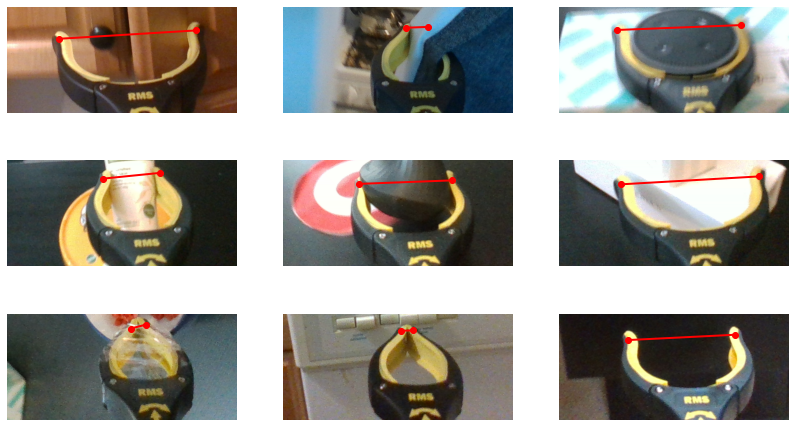

In [9]:
fig = plt.figure(figsize=(14, 8))
i = 0
n = 9
for i in range (n):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    _, label, img = training_data[sample_idx]
    label = [label[0]*IMG_WIDTH, label[1]*IMG_HEIGHT, 
                label[2]*IMG_WIDTH, label[3]*IMG_HEIGHT]
    img = np.flip(img, axis=-1) 
    #img = img.permute(2, 1, 0)
    ax = fig.add_subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.plot([label[0], label[2]], [label[1], label[3]], color='red', marker='o', linewidth=2)

## Networks from robot_baselines

In [10]:
def _linear(in_dim, out_dim, gain=1):
    layer = nn.Linear(in_dim, out_dim)
    nn.init.orthogonal_(layer.weight.data, gain=gain)
    nn.init.constant_(layer.bias.data, 0)
    return layer

class CNNPolicy(nn.Module):
    def __init__(self, features, adim=4, H=1):
        super().__init__()
        self._features = features
        f1, a1 = _linear(256, 256), nn.Tanh()
        f2 = _linear(256, adim * H)
        self._pi = nn.Sequential(f1, a1, f2)
        self._adim, self._H = adim, H
    
    def forward(self, images):
        feat = self._features(images)
        if self._H > 1:
            return self._pi(feat).reshape((-1, self._H, self._adim))
        return self._pi(feat).reshape((-1, self._adim))

class VGGSoftmax(nn.Module):
    def __init__(self, bias=None):
        super().__init__()
#         c1, a1 = nn.Conv2d(3, 64, 3, stride=1, padding=1), nn.ReLU(inplace=True)
#         c2, a2 = nn.Conv2d(64, 64, 3, stride=1, padding=1), nn.ReLU(inplace=True)
#         m1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
#         c3, a3 = nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(inplace=True)
#         c4, a4 = nn.Conv2d(128, 128, 3, stride=1, padding=1), nn.ReLU(inplace=True)
#         self.vgg = nn.Sequential(c1, a1, c2, a2, m1, c3, a3, c4, a4)
        self.vgg = nn.Sequential(vgg16.features[:9], vgg16.avgpool)
        self.extra_convs = nn.Conv2d(128, 128, 3, stride=2, padding=1)

    def forward(self, x):
        # vgg convs and 2D softmax
        x = self.vgg(x)
        x = self.extra_convs(x)
        B, C, H, W = x.shape
        x = F.softmax(x.view((B, C, H * W)), dim=2).view((B, C, H, W))

        # calculate and return expected keypoints
        h = torch.linspace(-1, 1, H).reshape((1, 1, -1)).to(x.device) * torch.sum(x, 3)
        w = torch.linspace(-1, 1, W).reshape((1, 1, -1)).to(x.device) * torch.sum(x, 2)
        return torch.cat([torch.sum(a, 2) for a in (h, w)], 1)

In [11]:
class Arguments:
    def __init__(self, **kwargs):
        args = self.default
        for k in kwargs.keys():
            if k not in args:
                print("WARNING: key {} not in defaults!".format(k))

        args.update(kwargs)
        for k, v in args.items():
            setattr(self, k, v)
    
    def default(self):
        raise NotImplementedError

class Metric:
    def __init__(self):
        self.reset()

    def reset(self):
        self._n = 0
        self._value = 0
    
    def add(self, value):
        self._value += value
        self._n += 1
    
    @property
    def mean(self):
        if self._n:
            return self._value / self._n
        return 0

## robot_baselines train code

In [12]:
loss_values = []
loss_values_indiv = []
test_loss = []

# build network and restore weights
features = VGGSoftmax()
Model = CNNPolicy
policy = Model(features, H=1).cuda()

def train(args):
    # create output folder
#     if not os.path.exists(args.output_folder):
#         os.makedirs(args.output_folder)

    # load dataset depending on arguments
#     if args.TRAJ:
#         train, test = baselines.datasets.traj_dataset(args.input_data, args.BATCH_SIZE)
#     elif args.H == 1:
#         train, test, _ = baselines.datasets.state_action_dataset(args.input_data, args.BATCH_SIZE)
#     else:
#         train, test = baselines.datasets.snippet_dataset(args.input_data, args.BATCH_SIZE, args.H)
    
    global policy
    
    train = train_dataloader
    test = test_dataloader
    
    # build optim
    train_metric, test_metric = Metric(), Metric()
    optim = torch.optim.Adam(policy.parameters(), lr=args.LR)
    loss = nn.SmoothL1Loss()
    for e in range(args.EPOCHS):
        train_metric.reset(); test_metric.reset()
        policy = policy.train()
        
        
        for image, label, img in train:            
            optim.zero_grad()
            pred = policy(image.cuda().float())
            train_loss = loss(pred, label.cuda().float())
            train_loss.backward()
            optim.step()
            train_metric.add(train_loss.item())
            loss_values_indiv.append(train_loss.item())
            print('epoch {} \t train {:.6f} \t\t'.format(e, train_loss.item()), end='\r')
        loss_values.append(train_metric.mean)
        
#         fig = plt.figure(figsize=(14, 8))
#         for i in range(9):
#             im = img[i].numpy()
#             l = label[i].numpy()
#             l = [l[0]*IMG_WIDTH, l[1]*IMG_HEIGHT, 
#                         l[2]*IMG_WIDTH, l[3]*IMG_HEIGHT]
#             im = np.flip(im, axis=-1) 
#             ax = fig.add_subplot(3, 3, i+1)
#             plt.axis('off')
#             #plt.imshow(im)
#             tim = image[i].permute(1, 2, 0).numpy()
#             #print(tim)
#             plt.imshow(im)
#             plt.plot([l[0], l[2]], [l[1], l[3]], color='red', marker='o', linewidth=2)
            
                
        
        policy = policy.eval()
        for image, label, _ in test:
            with torch.no_grad():
                pred = policy(image.cuda().float())
                test_metric.add(loss(pred, label.cuda()).item())
        print('epoch {} \t train {:.6f} \t test {:.6f}'.format(e, train_metric.mean, test_metric.mean))
        test_loss.append(test_metric.mean)
    
    print("\nDone!")

#         if (e + 1) % args.SAVE_FREQ == 0 or e + 1 == args.EPOCHS:
#             torch.save(policy.state_dict(), args.output_folder + '/policy_epoch{}.pt'.format(e))



In [13]:
class Arguments(Arguments):
    @property
    def default(self):
        return {
            'BATCH_SIZE': 64,
            'EPOCHS': 10,
            'LR': 5e-4,
            'H': 1,
        }
    
train(Arguments())

epoch 0 	 train 0.058795 	 test 0.019913
epoch 1 	 train 0.010790 	 test 0.007403
epoch 2 	 train 0.005604 	 test 0.004256
epoch 3 	 train 0.003840 	 test 0.003549
epoch 4 	 train 0.003046 	 test 0.003111
epoch 5 	 train 0.002568 	 test 0.002894
epoch 6 	 train 0.002255 	 test 0.002677
epoch 7 	 train 0.002007 	 test 0.002447
epoch 8 	 train 0.001815 	 test 0.002277
epoch 9 	 train 0.001657 	 test 0.002185

Done!


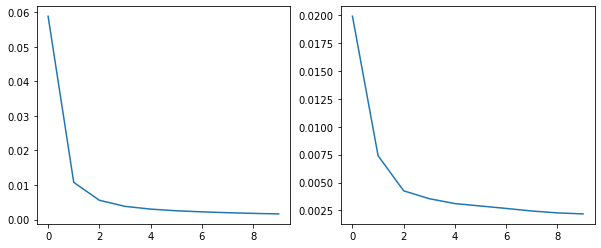

In [14]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1, 2, 1)
plt.plot(loss_values)
ax = fig.add_subplot(1, 2, 2)
plt.plot(test_loss)
plt.show()

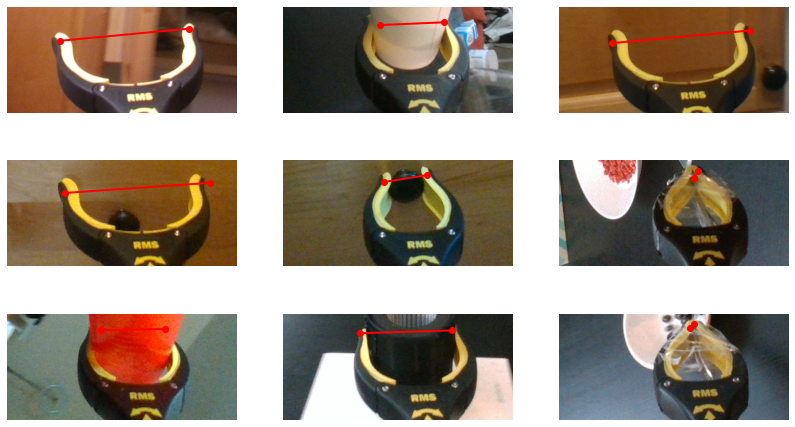

In [15]:
fig = plt.figure(figsize=(14, 8))
i = 0
n = 9
for i in range (n):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    transformed, _, img = training_data[sample_idx]
    label = policy(transformed.cuda().float().unsqueeze(dim=0))
    label = label.detach().cpu().squeeze(dim=0)
    label = [label[0]*IMG_WIDTH, label[1]*IMG_HEIGHT, 
                label[2]*IMG_WIDTH, label[3]*IMG_HEIGHT]
    img = np.flip(img, axis=-1) 
    ax = fig.add_subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.plot([label[0], label[2]], [label[1], label[3]], color='red', marker='o', linewidth=2)

In [63]:
class OnlyImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = test_transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        print(len(self.img_labels))
        print(self.img_dir)
        print(idx)
        print(self.img_labels.iloc[idx])
        #print(self.img_labels[idx])
        img_path = "push_nsh/" + self.img_labels[idx]
        with open(img_path, 'rb') as handle:
            frame_data = pickle.load(handle)
            image = frame_data['rgb']
            
        
        return image

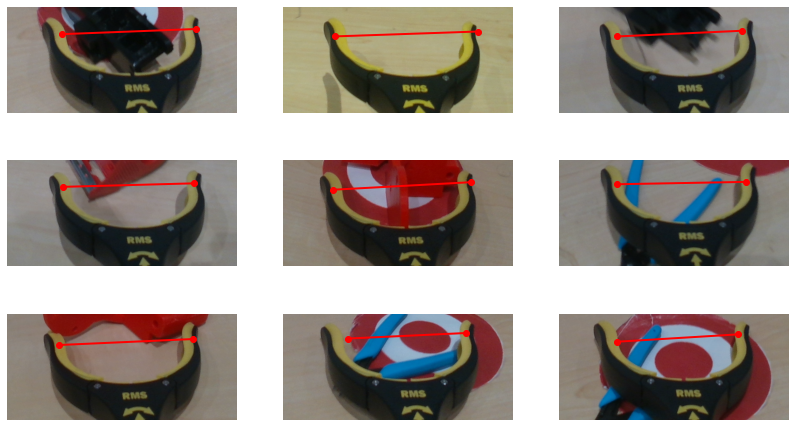

In [102]:
#nsh_data = OnlyImageDataset("push_nsh.csv", "push_nsh")
img_labels = pd.read_csv("push_nsh.csv").values.tolist()

fig = plt.figure(figsize=(14, 8))
i = 0
n = 9
for i in range (n):
    sample_idx = np.random.randint(0, len(img_labels))
    img_path = "push_nsh/" + img_labels[sample_idx][0]
    with open(img_path, 'rb') as handle:
        frame_data = pickle.load(handle)
        img = frame_data['rgb'][480::, 440:960:]
        transf = _TEST_TRANSFORM(Image.fromarray(img))
    label = policy(transf.cuda().float().unsqueeze(dim=0))
    label = label.detach().cpu().squeeze(dim=0)
    label = [label[0]*IMG_WIDTH, label[1]*IMG_HEIGHT, 
                label[2]*IMG_WIDTH, label[3]*IMG_HEIGHT]
    img = np.flip(img, axis=-1) 
    #img = img.permute(1, 2, 0)
    ax = fig.add_subplot(3, 3, i+1)
    plt.axis('off')
    plt.imshow(img)
    plt.plot([label[0], label[2]], [label[1], label[3]], color='red', marker='o', linewidth=2)#

## PyTorch tutorials train code

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [ ]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn)
print("Done!")